In [323]:
import torch 
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch import optim 
from torch.autograd import Variable
from copy import deepcopy
from captum.attr import IntegratedGradients

In [36]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())

In [189]:
mnist_trainset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [4]:
#mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)


1654784it [01:08, 31412.08it/s]

In [312]:
def process_data_set_binary_classif(dataset, classes=[1,8]):
    
    assert (type(classes)) == list  and (len(classes)==2), "classes must be a list of two elements"
    number_interesting_labels = torch.sum(dataset.targets == classes[0]).item() + torch.sum(dataset.targets == classes[1]).item()
    #binary_labels = torch.empty(number_interesting_labels, dtype=float)
    binary_labels = []
    binary_data = torch.empty(number_interesting_labels, 28, 28)
    
    for i, t in enumerate(dataset.targets):
        c=0
        #print(t.item())
        if t.item() in classes:
            if t.item() == classes[0]:
                binary_labels.append([1,0])
            else:
                binary_labels.append([0,1])
            binary_data[c, :,:] = dataset.data[i]
            c += 1
            
    return binary_data, torch.from_numpy(np.array(binary_labels))
    

In [313]:
d,l = process_data_set_binary_classif(mnist_trainset, classes=[1, 8])

In [314]:
l

tensor([[1, 0],
        [1, 0],
        [1, 0],
        ...,
        [1, 0],
        [0, 1],
        [0, 1]])

In [315]:
new_train = deepcopy(mnist_trainset)

In [316]:
new_train.data = d
new_train.targets = l
new_train.classes = ['1 - one',
                    '8 - eight']

In [334]:
Data_train = torch.utils.data.DataLoader(mnist_trainset, 
                                          batch_size=100, 
                                          shuffle=True,
                                          num_workers=1)

$ Out = In * W + Biais$

In [404]:
class CnnModel(nn.Module):
    def __init__(self):
        super(CnnModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, (5, 5), bias=True)
        self.flatt = nn.Flatten()
        self.dense1 = nn.Linear(576, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.flatt(x)
        x1 = self.dense1(x)
        return (self.softmax(x1))


In [405]:
net = CnnModel()

In [406]:
net(data_train[0:20].reshape(20,1,28,28)).shape

torch.Size([20, 10])

In [399]:
Data_train.labels

AttributeError: 'DataLoader' object has no attribute 'labels'

In [407]:
optimizer = optim.Adam(net.parameters(), lr = 0.001) 
loss_func = nn.CrossEntropyLoss() 
num_epochs = 10
total_step = len(Data_train)
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(Data_train):
        b_x = Variable(images)   # images
        b_y = Variable(labels)   # labels
        output = net(b_x)
        #print(b_y)
        #print(output)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        #break
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))


Epoch [1/10], Step [100/600], Loss: 1.7133
Epoch [1/10], Step [200/600], Loss: 1.6033
Epoch [1/10], Step [300/600], Loss: 1.5867
Epoch [1/10], Step [400/600], Loss: 1.5536
Epoch [1/10], Step [500/600], Loss: 1.5784
Epoch [1/10], Step [600/600], Loss: 1.5728
Epoch [2/10], Step [100/600], Loss: 1.6049
Epoch [2/10], Step [200/600], Loss: 1.6287
Epoch [2/10], Step [300/600], Loss: 1.5076
Epoch [2/10], Step [400/600], Loss: 1.5479
Epoch [2/10], Step [500/600], Loss: 1.5895
Epoch [2/10], Step [600/600], Loss: 1.5763
Epoch [3/10], Step [100/600], Loss: 1.5390
Epoch [3/10], Step [200/600], Loss: 1.5710
Epoch [3/10], Step [300/600], Loss: 1.5834
Epoch [3/10], Step [400/600], Loss: 1.5492
Epoch [3/10], Step [500/600], Loss: 1.5372
Epoch [3/10], Step [600/600], Loss: 1.6057
Epoch [4/10], Step [100/600], Loss: 1.5536
Epoch [4/10], Step [200/600], Loss: 1.5728
Epoch [4/10], Step [300/600], Loss: 1.5655
Epoch [4/10], Step [400/600], Loss: 1.5733
Epoch [4/10], Step [500/600], Loss: 1.5498
Epoch [4/10

In [408]:
conv = net.conv1.weight.reshape(5,5).detach().numpy()

In [409]:
net.dense1.weight.shape

torch.Size([10, 576])

In [469]:
w = net.dense1.weight[5].reshape(24,24).detach().numpy()
#w = net.dense1.weight[0].reshape(24,24).detach().numpy()

In [470]:
import matplotlib.pyplot as plt

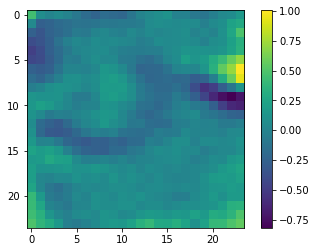

In [471]:
plt.imshow(w)
plt.colorbar()

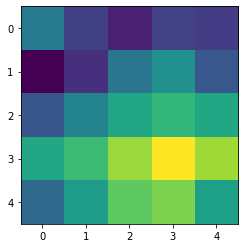

In [439]:
plt.imshow(conv)

In [440]:
nexte = iter(Data_train)

In [458]:
input1 = nexte.next()[0][0].reshape(1,1,28,28)
i = input1.detach().numpy().reshape(28,28)

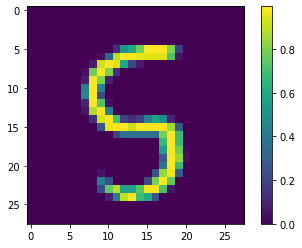

In [459]:
plt.imshow(i)
plt.colorbar()

In [460]:
out_full = net(torch.from_numpy(i).reshape(1,1,28,28)).detach().numpy()
out = net.conv1(torch.from_numpy(i).reshape(1,1,28,28)).reshape(24,24).detach().numpy()

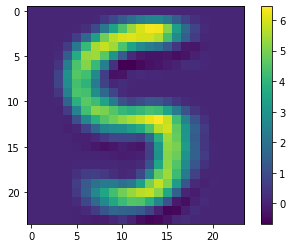

In [461]:
plt.imshow(out)
plt.colorbar()

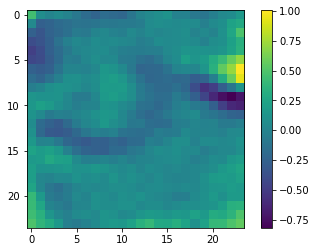

In [472]:
plt.imshow(w)
plt.colorbar()

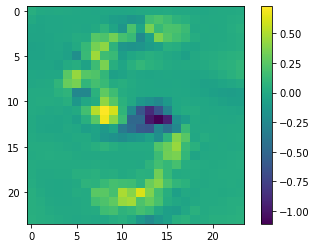

In [473]:
plt.imshow((out*w))
plt.colorbar()

In [272]:
net.dense1.bias

Parameter containing:
tensor([-0.0140, -0.0196], requires_grad=True)

In [474]:

input1.require_grad = True

In [475]:
base = torch.zeros((1,1,28,28))

In [476]:
input1.shape

torch.Size([1, 1, 28, 28])

In [477]:
ig = IntegratedGradients(net)

In [478]:
attributions= ig.attribute(input1,target=8)

In [479]:
new_att = attributions.reshape((28,28))

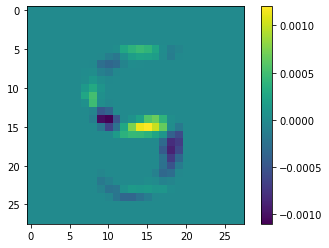

In [480]:
plt.imshow(new_att)
plt.colorbar()

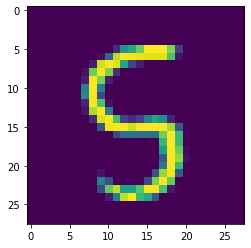

In [481]:
plt.imshow(input1.reshape(28,28))

In [482]:
torch.argmax(net(input1).reshape(10))

tensor(5)